In [20]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# Hands-on clustering #2:
## Recommender system using Non-negative Matrix Factorization: MovieLens

## 2. Data exploration

#### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns
sns.set_theme(style="darkgrid")

### 2.1. Load the dataset

In [2]:
# Loading ratings 
names = ["User ID", "Movie ID", "Rating"]
ratings_df = pd.read_csv("Data/ml-100k/u.data", sep="\t", usecols=[0,1,2], names=names)

### 2.2 Understand the data

#### Display first few columns

In [3]:
ratings_df.head()

,User ID,Movie ID,Rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


#### Check data dimensions

In [4]:
n_ratings = ratings_df.shape[0]
n_users = len(ratings_df["User ID"].unique())
n_items = len(ratings_df["Movie ID"].unique())

print("Total number of ratings in the dataset: %i" % (n_ratings))
print("Number of persons who rated movies: %i" % (n_users))
print("Number of rated movies: %i" % (n_items))

Total number of ratings in the dataset: 100000
Number of persons who rated movies: 943
Number of rated movies: 1682


#### Statistics of the ratings

In [5]:
summary = ratings_df["Rating"].describe()
summary

count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: Rating, dtype: float64

### 2.3. Histogram of the ratings

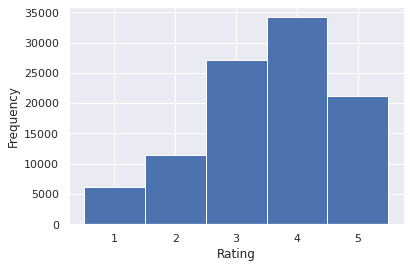

In [6]:
plt.hist(ratings_df["Rating"], bins=range(1, 7), align="left")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.grid(True)

##### Interpretation

- We might want to normalize accross the users, to ensure that each have them have the same rating scales.\
- However, we need to be careful in the transformation we apply to the data. Indeed, bringing the data to standard normal distribution would break the non-negativity of the data, and we could not apply NMF anymore.\
- For this study, no normalization will be applied.

### 2.4. Ratings per user

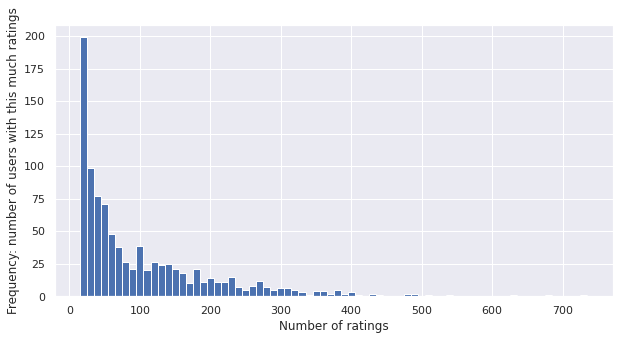

In [7]:
users_list = range(1, n_users + 1)
n_ratings = [np.count_nonzero(ratings_df["User ID"] == i) for i in users_list]
n_ratings = np.array(n_ratings)

binwidth = 10
bins = np.arange(min(n_ratings), max(n_ratings)+binwidth, binwidth)
plt.figure(figsize=(10,5))
plt.hist(n_ratings, bins=bins, align="left")
plt.xlabel("Number of ratings")
plt.ylabel("Frequency: number of users with this much ratings")
plt.show()

#### Statistics

In [8]:
n_ratings_df = pd.DataFrame(n_ratings)
summary = n_ratings_df.describe()

summary

,0
count,943.000000
mean,106.044539
std,100.931743
min,20.000000
25%,33.000000
50%,65.000000
75%,148.000000
max,737.000000


##### Interpretation

- The average number of ratings per user is below fifty.
- The minimum is twenty (that's how the dataset is built)
- Some users rated many movies (more than 700)

### 2.5. Average ratings per movie

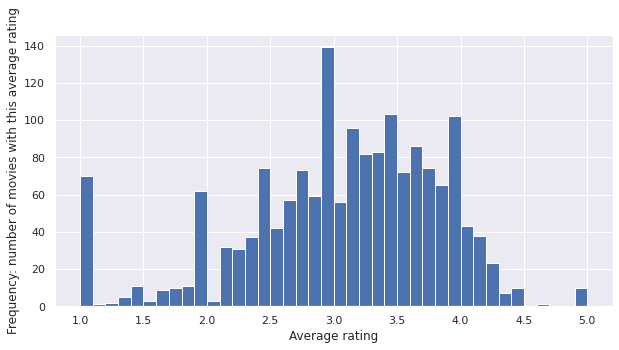

In [9]:
movies_list = range(1, n_items + 1)
mean_ratings = [ratings_df["Rating"][ratings_df["Movie ID"] == i].mean() for i in movies_list]
mean_ratings = np.array(mean_ratings)

binwidth = 0.1
bins = np.arange(min(mean_ratings), max(mean_ratings)+binwidth, binwidth)
plt.figure(figsize=(10,5))
plt.hist(mean_ratings, bins=bins, align="mid")
plt.xlabel("Average rating")
plt.ylabel("Frequency: number of movies with this average rating")
plt.show()

##### Interpretation

- Spikes on exact values: several movies had unanimous ratings.
- Spikes on 1 and 5: Some users might have a binary rating scale (like or dislike).

#### Find movies with ratings 1 and 5

In [10]:
# Loading movies titles
movie_titles = pd.read_csv("Data/ml-100k/u.item", sep="|", header=None, usecols=[1], 
                           encoding='iso-8859-1', names=["Title"])

bad_movies, good_movies = [], []
for i in range(len(mean_ratings)):
    if mean_ratings[i] == 1:
        bad_movies.append(movie_titles["Title"][i])
    if mean_ratings[i] == 5:
        good_movies.append(movie_titles["Title"][i])

print("Example of movie with rating of 1:", np.random.choice(bad_movies))
print("Example of movie with rating of 5:", np.random.choice(good_movies))

Example of movie with rating of 1: Hostile Intentions (1994)
Example of movie with rating of 5: Aiqing wansui (1994)


## 3. Applying NMF

### 3.1. Build the user-item matrix

In [11]:
from scipy import sparse

users = ratings_df["User ID"].values
movies = ratings_df["Movie ID"].values
rating = ratings_df["Rating"].values

matrix_sparse = sparse.csr_matrix((rating, (users, movies)), shape=(n_users+1, n_items+1))
R = matrix_sparse.todense()
R = np.array(R[1:, 1:])

print("Verify rating of user 196 for movie 242 (first row in data file): ", R[195, 241])

Verify rating of user 196 for movie 242 (first row in data file):  3


### 3.2. Sparsity of user-item matrix

In [12]:
sparsity = 1 - len(R.nonzero()[0]) / (R.shape[0] * R.shape[1])
print("Sparsity of R: %0.2f%%" % (sparsity * 100))

Sparsity of R: 93.70%


##### Interpretation

6.30% of the user-item ratings have a value. Missing values are filled with zeros but they do not represent zero on the same scale as the ratings, they are simply empty entries. Ratings are defined from 1 to 5.

### 3.3 Apply NMF with 20 components

In [13]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=20, init="nndsvda", max_iter=int(1e3))
nmf.fit(R)
W = nmf.transform(R)
H = nmf.components_

print("Number of iterations: ", nmf.n_iter_)
print("Movies features shape (transpose(H)): ", H.T.shape)
print("Users features shape (W): ", W.shape)
print("Reconstruction of R shape (W.H): ", W.dot(H).shape)

Number of iterations:  943
Movies features shape (transpose(H)):  (1682, 20)
Users features shape (W):  (943, 20)
Reconstruction of R shape (W.H):  (943, 1682)


##### Interpretation

The algorithm converged, the shapes of the matrices are as expected.

### 3.4 Identify topics

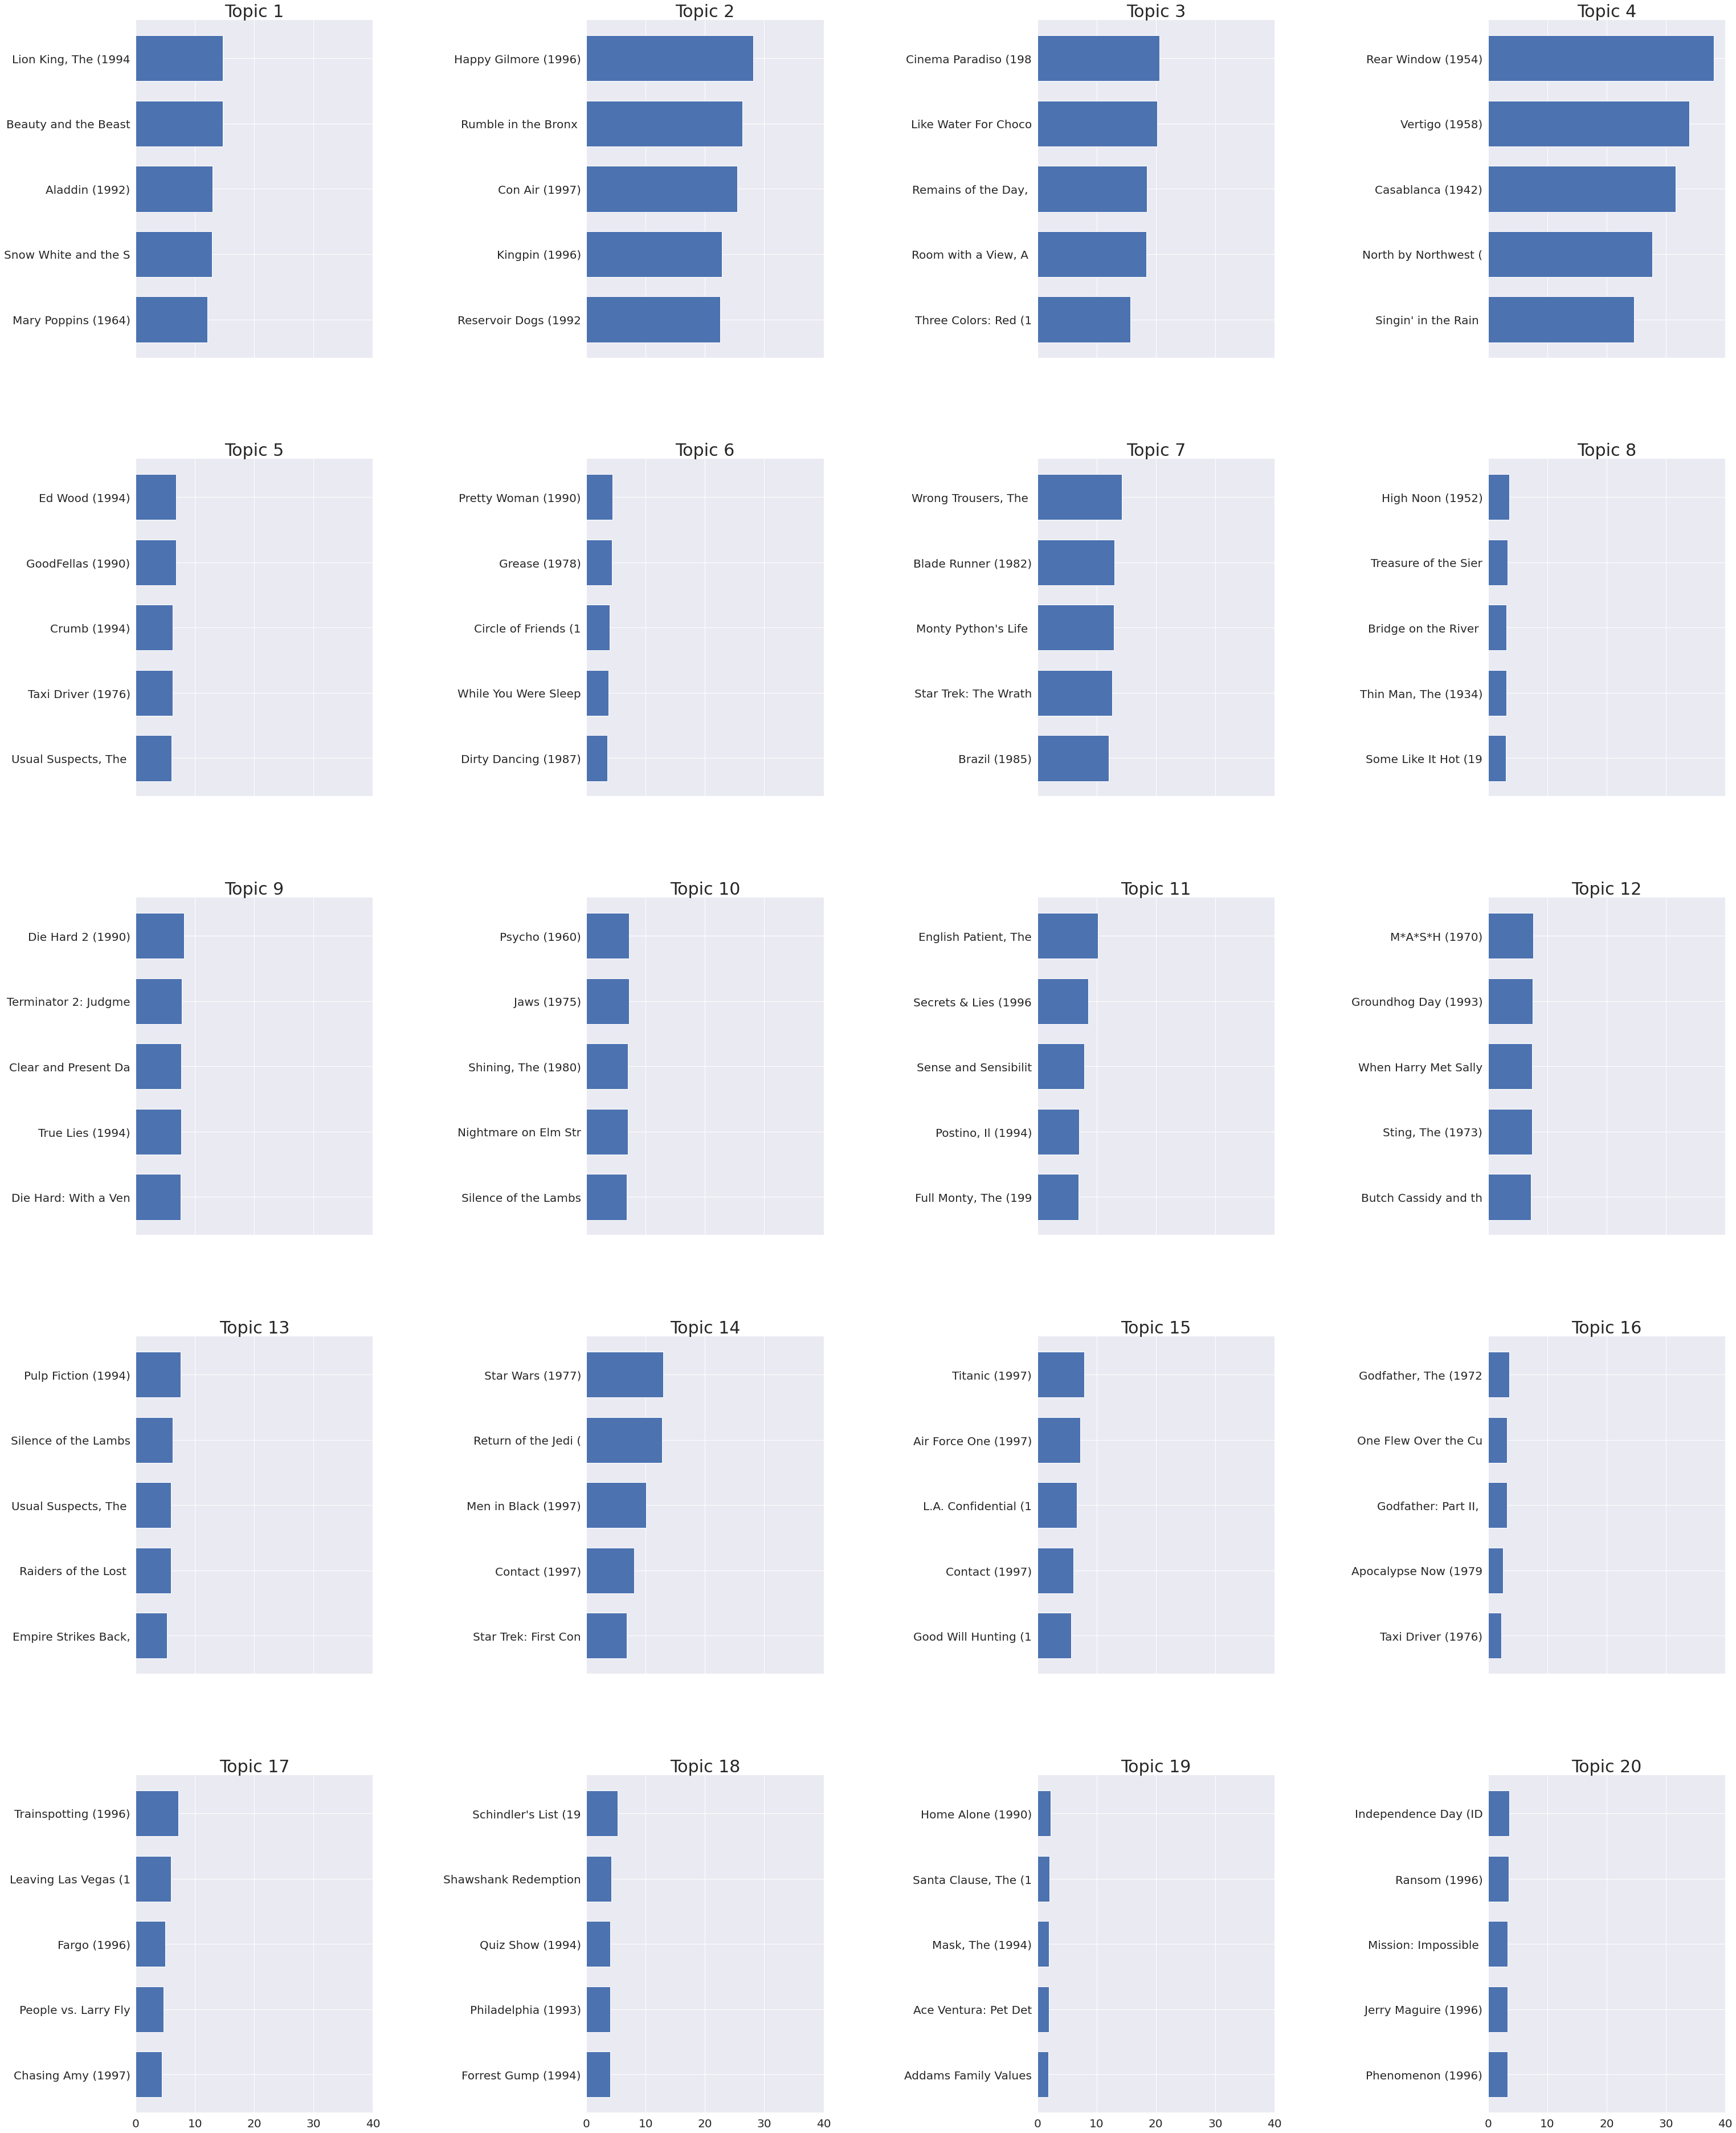

In [27]:
n_top_words = 5
fig, axes = plt.subplots(5, 4, figsize=(50, 60), sharex=True)
axes = axes.flatten()
for i in range(H.shape[0]):
    topic = H[i, :]
    top_features = topic.argsort()[: -n_top_words - 1 : -1]
    top_features_names = [movie_titles["Title"][j][:20] for j in top_features]
    top_features_scores = [topic[j] for j in top_features]

    ax = axes[i]
    ax.barh(top_features_names, top_features_scores, height=0.7)
    ax.set_title(f"Topic {i+1}", fontdict={"fontsize": 30})
    ax.invert_yaxis()
    ax.tick_params(axis="both", which="major", labelsize=20)
    for i in "top right left".split():
        ax.spines[i].set_visible(False)

plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
plt.show()

##### Interpretation

We can clearly see that most topics correspond to different movie genres.\
\
__Examples__:
- Topic 1: Animation movies
- Topic 9: Action movies
- Topic 10: Horror movies
- Topic 18: Drama movies
- ...

### 3.5 Average reconstruction error

In [28]:
R_pred = W.dot(H)

print("Average reconstruction error: ", np.linalg.norm(R - R_pred) / (R.shape[0]*R.shape[1]))

Average reconstruction error:  0.0005283608294877248


### 3.6 Clip values outside rating scale

In [29]:
print(R)
R_pred = W.dot(H)
R_pred[R_pred > 5] = 5.
R_pred[R_pred < 1] = 1.

print(R_pred.astype(np.int8))

[[5 3 4 ... 0 0 0]
 [4 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [5 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 5 0 ... 0 0 0]]
[[4 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [2 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 2 1 ... 1 1 1]]


##### Interpretation

We want to make recommendations to the users. In other words, we want to estimate the rating a movie would get when this rating does not exist. This way, we give a valid rating to all of the movies in the new reconstructed matrix.

## 4. Make recommendations

### 4.1 Known User 

#### 4.1.1 Recommend five movies to random user

In [50]:
n_recommendations = 5
user_idx = np.random.randint(n_users)
ratings_user = R[user_idx, :]
predictions_user = R_pred[user_idx, :]

unseen_indices = np.where(ratings_user == 0)[0]
predictions_unseen = predictions_user[unseen_indices]
print("Recommended movies for user %i:" % user_idx)
print("\nTitle | Rating\n-------------------------------")
predicted_movies_index = np.argsort(-predictions_unseen)
for i in range(n_recommendations):
    index = unseen_indices[predicted_movies_index[i]]
    print(movie_titles["Title"][index], "|", predictions_user[index])

Recommended movies for user 618:

Title | Rating
-------------------------------
Star Trek IV: The Voyage Home (1986) | 3.318500141351434
Star Trek: First Contact (1996) | 3.2381918072829987
Star Trek: The Wrath of Khan (1982) | 3.0814680217835817
Star Trek VI: The Undiscovered Country (1991) | 2.9516459042839456
Blade Runner (1982) | 2.9095076753997855


#### 4.1.2 Compare with favorite movies

In [51]:
print("Favorite movies for user %i:" % user_idx)
print("\nTitle | Rating\n-------------------------------")
favorite_movies_index = np.argsort(-ratings_user)
for i in range(n_recommendations):
    index = favorite_movies_index[i]
    print(movie_titles["Title"][index], " | ", ratings_user[index])

Favorite movies for user 618:

Title | Rating
-------------------------------
Alien (1979)  |  5
Air Force One (1997)  |  5
Independence Day (ID4) (1996)  |  5
Die Hard: With a Vengeance (1995)  |  5
Aliens (1986)  |  5


##### Interpretation

Generally speaking, the movies recommended movies appear to be relevant when running the code on several users.\
\
We can also see many movies from the same year, which might mean that the dataset has some bias, where some users only rated movies from specific years.



#### 4.1.3 Topics used for recommendation

In [61]:
topics_used = W[i, :]
top_topics = topics_used.argsort()[: -3 - 1 : -1]
print("Top topics: %i, %i, %i" % tuple(top_topics + 1))

Top topics: 19, 7, 12


### 4.2 New user with rating history

#### 4.2.1 Creating a new user profile

In [32]:
my_ratings = np.zeros((1682,1), dtype=int)
my_ratings[0] = 4 
my_ratings[1] = 4 
my_ratings[10] = 1 
my_ratings[15] = 3
my_ratings[27] = 4
my_ratings[34] = 1
my_ratings[49] = 1
my_ratings[55] = 1
my_ratings[61] = 1
my_ratings[68] = 5
my_ratings[70] = 4
my_ratings[81] = 4
my_ratings[87] = 2
my_ratings[94] = 4
my_ratings[120] = 2
my_ratings[171] = 1
my_ratings[173] = 4
my_ratings[175] = 1
my_ratings[182] = 1
my_ratings[194] = 2
my_ratings[203] = 5
my_ratings[209] = 5
my_ratings[221] = 1
my_ratings[234] = 2
my_ratings[312] = 3
my_ratings[317] = 3
my_ratings[322] = 3
my_ratings[342] = 1
my_ratings[378] = 1
my_ratings[379] = 1
my_ratings[392] = 3
my_ratings[404] = 2
my_ratings[422] = 4
my_ratings[542] = 4

#### 4.1.2 Recommendations for new user

##### Recompute NMF

In [64]:
newR = np.r_[R, my_ratings.T]

new_nmf = NMF(n_components=20, init="nndsvda", max_iter=int(1e3))
new_nmf.fit(R)
newW = new_nmf.transform(R)
newH = new_nmf.components_

newR_pred = newW.dot(newH)
newR_pred[newR_pred > 5] = 5.
newR_pred[newR_pred < 1] = 1.

##### Make recommendations

In [66]:
n_recommendations = 5
user_idx = -1
ratings_user = newR[user_idx, :]
predictions_user = newR_pred[user_idx, :]

print("Preferred movies for new user:")
print("\nTitle | Rating\n-------------------------------")
favorite_movies_index = np.argsort(-ratings_user)
for i in range(n_recommendations):
    index = favorite_movies_index[i]
    print(movie_titles["Title"][index], " | ", ratings_user[index])

unseen_indices = np.where(ratings_user == 0)[0]
predictions_unseen = predictions_user[unseen_indices]
print("\n\nRecommended movies for new user:")
print("\nTitle | Rating\n-------------------------------")
predicted_movies_index = np.argsort(-predictions_unseen)
for i in range(n_recommendations):
    index = unseen_indices[predicted_movies_index[i]]
    print(movie_titles["Title"][index], " | ", predictions_user[index])

Preferred movies for new user:

Title | Rating
-------------------------------
Forrest Gump (1994)  |  5
Back to the Future (1985)  |  5
Indiana Jones and the Last Crusade (1989)  |  5
Toy Story (1995)  |  4
GoldenEye (1995)  |  4


Recommended movies for new user:

Title | Rating
-------------------------------
Silence of the Lambs, The (1991)  |  4.5334802558892235
Fugitive, The (1993)  |  4.4102829144450375
Braveheart (1995)  |  4.284727234479159
Usual Suspects, The (1995)  |  4.1365502727502985
Terminator 2: Judgment Day (1991)  |  4.107876104420134


### 4.3 New user with no rating history

#### 4.3.1 Similarity between movies

In [69]:
from sklearn.metrics.pairwise import cosine_similarity

movies_sim = cosine_similarity(H.T)

print(movies_sim.shape)

(1682, 1682)


#### 4.3.2 Visualize similarity matrix

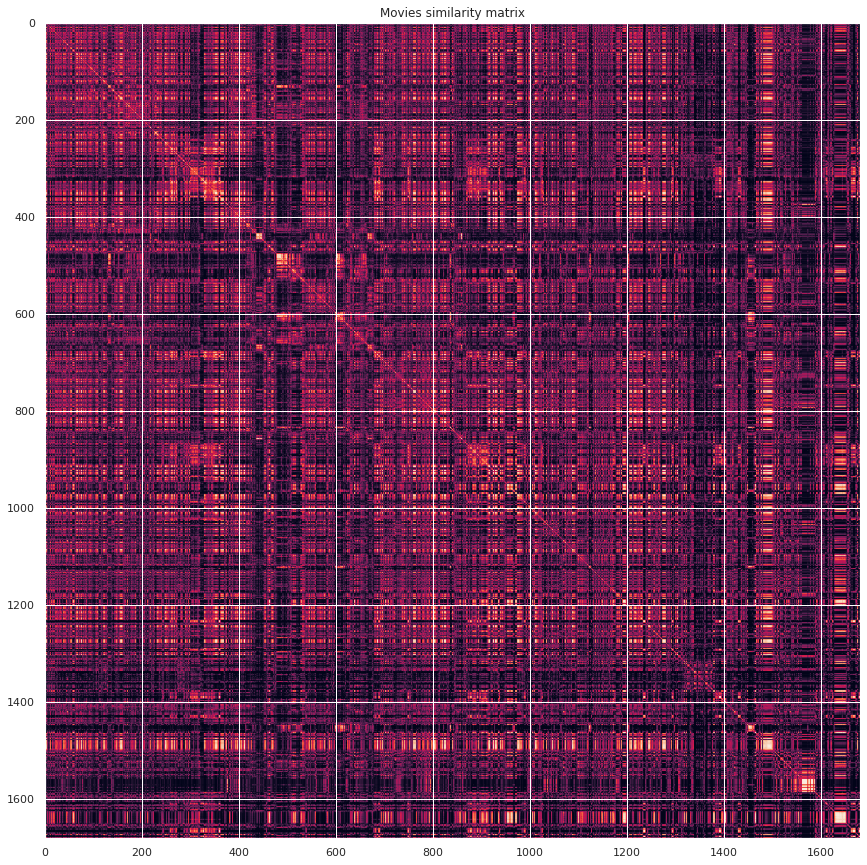

In [71]:
plt.figure(figsize=(15,15))
plt.imshow(movies_sim)
plt.title("Movies similarity matrix")
plt.show()

#### 4.3.3 Recommend most similar to movie to currently watching

In [72]:
n_recommendations = 5

watch_index = np.random.randint(0, len(movie_titles["Title"]))
print("Currently watching: ", movie_titles["Title"][watch_index])

movies_similarities = movies_sim[watch_index, :]
suggestions = np.argsort(-movies_similarities)[1:n_recommendations + 1]

print("\n\nRecommended movies for user:")
print("\nTitle | Similarity\n-------------------------------")
for i in suggestions:
    print(movie_titles["Title"][i], " | ", movies_similarities[i])

Currently watching:  Ghost and the Darkness, The (1996)


Recommended movies for user:

Title | Similarity
-------------------------------
Absolute Power (1997)  |  0.9849636935941368
Fear (1996)  |  0.9844887500214805
Set It Off (1996)  |  0.9843132569872154
Extreme Measures (1996)  |  0.983527288818739
Down Periscope (1996)  |  0.9818102926150292
